In [48]:
import pandas as pd
import numpy as np
import scipy.stats as st
    
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="darkgrid")
#import bayespy 

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz
print(f"Running on PyMC3 v{pm.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on PyMC3 v3.11.4


In [65]:
data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

# data_netw = pd.read_csv('../data/tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)

# Filter the rows where sum of the values = 0
# data = data[data.iloc[:,:-1].sum(axis=1)!=0]

In [50]:
data.head()

,TV_ANE,TV_AMC,TV_ANIMALPLANET,TV_BBCAMERICA,TV_BET,TV_BETHER,TV_BRAVO,TV_COMEDYCENTRAL,TV_COUNTRYMUSICTELEVISION,TV_FOODNETWORK,...,TV_SMITHSONIANNETWORK,TV_SYFY,TV_TRUTV,TV_TVONE,TV_USANETWORK,TV_VH1,TV_WETV,DIGITAL_HX,DIGITAL_TREMOR,TOTAL_CONV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.39,0.0,16
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.00,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0


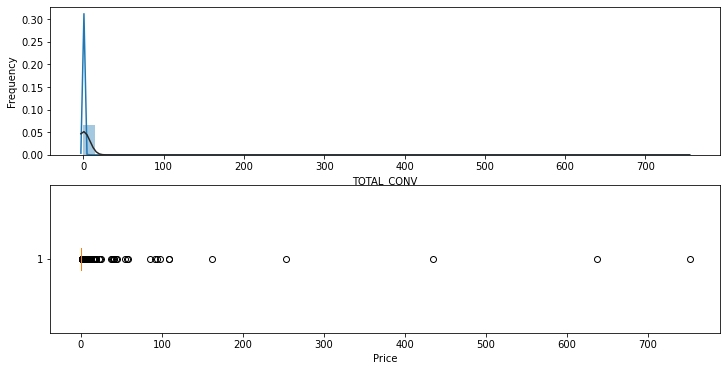

In [51]:
target_distribution(data.TOTAL_CONV)

In [66]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<10)] # & (data.TOTAL_CONV!=0)

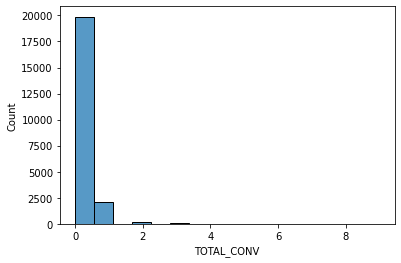

In [67]:
sns.histplot(data.TOTAL_CONV, )
plt.show()

In [68]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [69]:
print(f"Mean of target distribution: {round(y.mean(), 2)}")
print(f"Variance of target distribution: {round(y.std(), 2)}")

Mean of target distribution: 0.13
Variance of target distribution: 0.45


### NegativeBinomial as Likelihood
    Negative binomial regression is used to model count data for which the variance is higher than the mean (calls overdispersion). The negative binomial distribution can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance. When var == mean we could use Poisson distribution

In [175]:
with pm.Model() as model_negative_binomial:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        # Error term
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        # Likelihood
        conv = pm.NegativeBinomial('conv', 
                                   mu = mu,  
                                   alpha= eps,  
                                   observed=y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        # trace_negative_binomial = pm.sample(chains = 4, target_accept = 0.95)

In [176]:
# with model_negative_binomial:
#     trace_negative_binomial = pm.load_trace(directory=r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_nb")

In [256]:
idata_nb = generate_idata(trace = trace_negative_binomial, 
                          model = model_negative_binomial,
                          y = y)

In [281]:
idata_nb_f = generate_idata(trace = trace_negative_binomial, 
                          model = model_negative_binomial, 
                          filtered=True,
                          y = y)

In [ ]:
def plot_idata(idata):
    fig, ax = plt.subplots(figsize = (8,6))
    az.plot_ppc(idata, mean= True, ax=ax)
    ax.axvline(idata.observed_data.conv.values.mean(), ls="-", color="g", label="True mean")
    ax.axvline(idata.posterior_predictive.conv.values.flatten().mean(), 
               ls="--", color="r", label="Predictions mean")
    ax.legend(fontsize=10);
    plt.show()

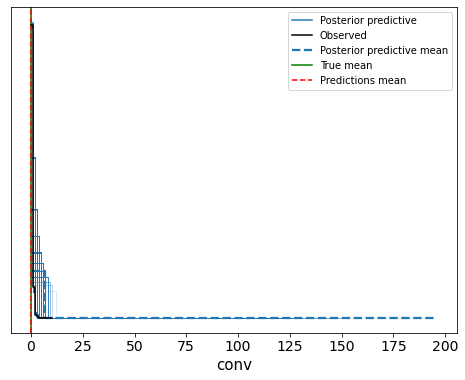

In [232]:
plot_idata(idata_nb)

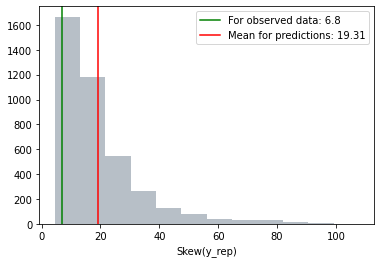

In [233]:
plot_scewness(idata_nb)

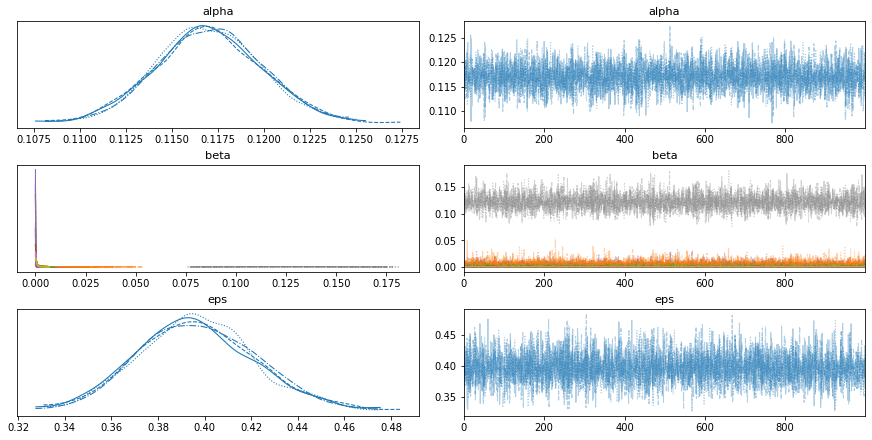

In [187]:
az.plot_trace(trace_negative_binomial)
plt.show()

In [47]:
# # saving trace
# pm.save_trace(trace=trace_negative_binomial, 
#               directory= r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_nb")

'c:\\Users\\izakharchuk\\Documents\\Starkis\\traces\\trace_nb'

### GLM Negative Binomial

In [234]:
# specifying priors and formula
formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

In [235]:
d_coef = {}
for val in data.columns[:-1]:
    d_coef[val] = d_coef.get(val, pm.HalfNormal.dist())

d_intercept = {'Intercept': pm.Normal.dist()}

# combining priors
d_priors = {**d_intercept,**d_coef}

In [239]:
# Context for the model
with pm.Model() as model_glm_nb:
    family = pm.glm.families.NegativeBinomial()
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula,
                        data = data, 
                        priors = d_priors, 
                        family= family)
    
    # trace_glm_nb = pm.sample(chains=4,  target_accept = 0.95)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, mu, DIGITAL_TREMOR, DIGITAL_HX, TV_WETV, TV_VH1, TV_USANETWORK, TV_TVONE, TV_TRUTV, TV_SYFY, TV_SMITHSONIANNETWORK, TV_POP, TV_PARAMOUNTNETWORK, TV_OVATIONTV, TV_OTHER, TV_OPRAHWINFREYNETWORK, TV_LIFETIMEMOVIES, TV_LIFETIME, TV_INVESTIGATIONDISCOVERY, TV_IFC, TV_GAMESHOWNETWORK, TV_FOODNETWORK, TV_COUNTRYMUSICTELEVISION, TV_COMEDYCENTRAL, TV_BRAVO, TV_BETHER, TV_BET, TV_BBCAMERICA, TV_ANIMALPLANET, TV_AMC, TV_ANE, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1589 seconds.


In [43]:
# with model_glm_nb:
#     trace_glm_nb = pm.load_trace(directory=r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_glm_nb")

In [246]:
# az.plot_trace(trace_glm_nb)

In [250]:
az.summary(trace_glm_nb)[["mean", "hdi_3%", "hdi_97%"]].T

,Intercept,TV_ANE,TV_AMC,TV_ANIMALPLANET,TV_BBCAMERICA,TV_BET,TV_BETHER,TV_BRAVO,TV_COMEDYCENTRAL,TV_COUNTRYMUSICTELEVISION,...,TV_SYFY,TV_TRUTV,TV_TVONE,TV_USANETWORK,TV_VH1,TV_WETV,DIGITAL_HX,DIGITAL_TREMOR,mu,alpha
mean,-2.074,0.003,0.003,0.002,0.023,0.001,0.020,0.002,0.004,0.001,...,0.036,0.008,0.004,0.001,0.002,0.003,0.076,0.002,123.060,0.377
hdi_3%,-2.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.044,0.000,0.008,0.335
hdi_97%,-2.033,0.007,0.009,0.006,0.064,0.002,0.055,0.004,0.011,0.003,...,0.098,0.022,0.010,0.002,0.006,0.009,0.109,0.004,99.122,0.425


In [249]:
# az.plot_forest(trace_glm_nb)

In [242]:
# # saving trace:
# pm.save_trace(trace=trace_glm_nb, 
#               directory= r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_glm_nb")

'c:\\Users\\izakharchuk\\Documents\\Starkis\\traces\\trace_glm_nb'

### ZeroInflated Poisson as Likelihood

In [240]:
with pm.Model() as model_zip:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd= 10, shape = len(data.columns[:-1]))
        psi = pm.Beta('psi', 1, 1)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        # Likelihood
        conv = pm.ZeroInflatedPoisson('conv', 
                                      theta= mu, 
                                      psi= psi,  
                                      observed=y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        # trace_zip = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1371 seconds.


In [52]:
# with model_zip:
#     trace_zip = pm.load_trace(directory=r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_zip")

In [257]:
idata_zip = generate_idata(trace = trace_zip, 
                           model = model_zip,
                           y = y)

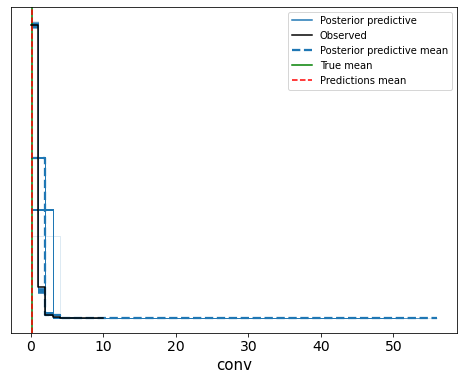

In [258]:
plot_idata(idata_zip)

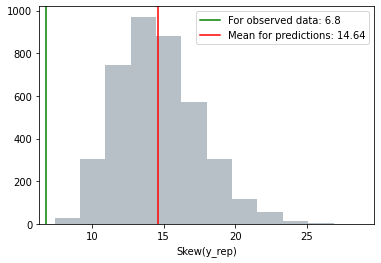

In [259]:
plot_scewness(idata_zip)

In [243]:
# # saving trace:
# pm.save_trace(trace=trace_zip, 
#               directory= r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_zip")

'c:\\Users\\izakharchuk\\Documents\\Starkis\\traces\\trace_zip'

### ZeroInflatedNegativeBinomial for Likelihood Function

In [241]:
with pm.Model() as model_zinb:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        psi = pm.Beta('psi', 1, 1)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        
        conv = pm.ZeroInflatedNegativeBinomial('conv', 
                                              mu = mu,
                                              psi = psi,
                                              alpha = eps,
                                              observed = y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        # trace_zinb = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3580 seconds.
The acceptance probability does not match the target. It is 0.8844715870418747, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [57]:
# with model_zinb:
#     trace_zinb = pm.load_trace(directory=r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_zinb")

In [260]:
idata_zinb = generate_idata(trace = trace_zinb, 
                            model = model_zinb,
                            y = y)

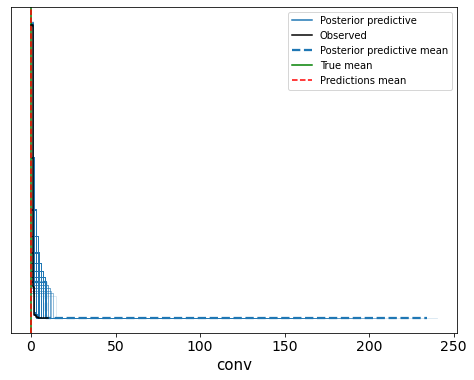

In [261]:
plot_idata(idata_zinb)

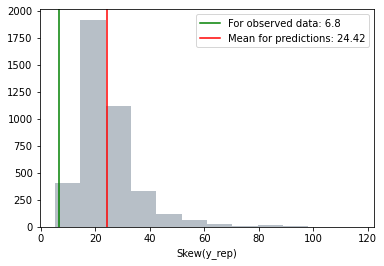

In [262]:
plot_scewness(idata_zinb)

In [244]:
# # saving trace:
# pm.save_trace(trace=trace_zinb, 
#               directory= r"c:\Users\izakharchuk\Documents\Starkis\traces\trace_zinb")

'c:\\Users\\izakharchuk\\Documents\\Starkis\\traces\\trace_zinb'

### Model Comparison

In [264]:
cmp_df = az.compare({'NegativeBinomial':trace_negative_binomial, 
                     'ZeroInflatedPoisson':trace_zip,
                     'ZeroInfNegBinom':trace_zinb,
                     'GLM_NegativeBinomial':trace_glm_nb, 
                    })
cmp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
NegativeBinomial,0,-8829.600303,5.893688,0.000000,0.634651,132.440134,0.000000,False,log
ZeroInfNegBinom,1,-8859.782535,28.657778,30.182232,0.000000,133.026732,9.048686,False,log
GLM_NegativeBinomial,2,-8900.629359,6.267184,71.029056,0.136903,136.889683,18.071315,False,log
ZeroInflatedPoisson,3,-8930.593892,9.639967,100.993589,0.228446,141.449611,26.193167,False,log


The index is the names of the models taken from the keys of the dictionary passed to compare(.).

rank, the ranking of the models starting from 0 (best model) to the number of models.

loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

warning, If True the computation of LOO/WAIC may not be reliable.

loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

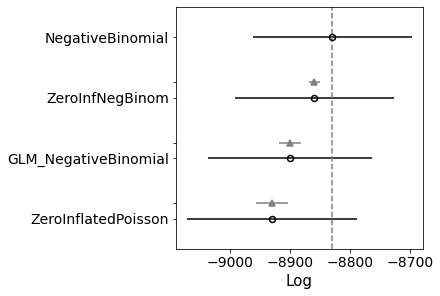

In [265]:
az.plot_compare(cmp_df, insample_dev=False)
plt.show()

The empty circle represents the values of LOO and the black error bars associated with them are the values of the standard deviation of LOO.

The value of the highest LOO, i.e the best estimated model, is also indicated with a vertical dashed grey line to ease comparison with other LOO values.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

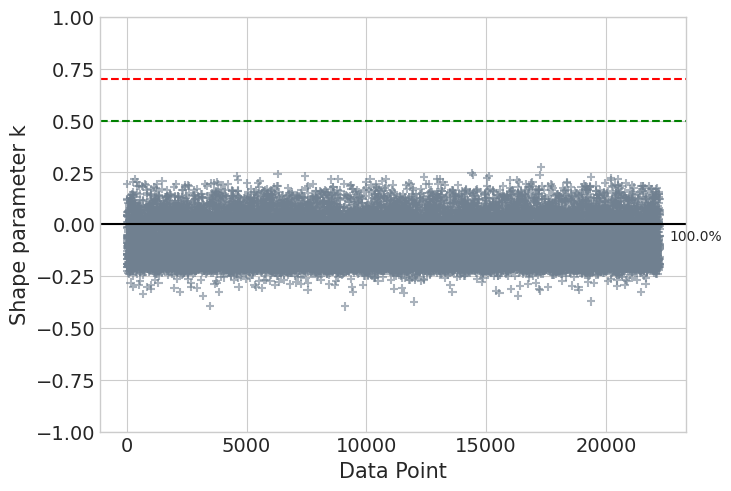

In [266]:
# compute with arviz InferenceData type
p_loo_zinb = pm.loo(trace_negative_binomial, pointwise=True, var_name='conv')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(p_loo_zinb, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0.5, color = 'green', linestyle='dashed')
plt.axhline(0.7, color = 'red', linestyle='dashed')
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

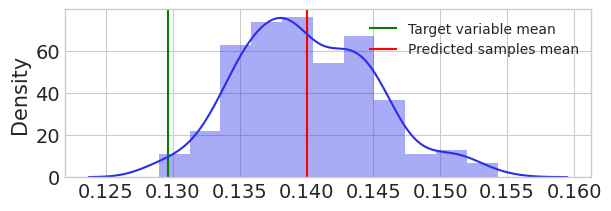

In [267]:
samples_mean = [sample.mean() for sample in predictions_negative_binomial['conv']]

plt.figure(figsize=(6,2))
ax = sns.distplot(samples_mean,)
plt.vlines(y.mean(), *ax.set_ylim(), color='g', label='Target variable mean')
plt.vlines(predictions_negative_binomial['conv'].flatten().mean(), 
           *ax.set_ylim(),
           label='Predicted samples mean',  
           color='r')
plt.legend(loc=1, fontsize ='medium')
plt.show()

In [269]:
coeff_nb = az.summary(var_names='beta', 
                      data=trace_negative_binomial, 
                     ).set_index(data.columns[:-1],
                                ).rename(columns={'mean':'NegBinomial_Coeff'},)['NegBinomial_Coeff']

In [270]:
coeff_zinb = az.summary(var_names='beta', 
                        data=trace_zinb, 
                       ).set_index(data.columns[:-1],
                                  ).rename(columns={'mean':'ZeroInfNB_Coeff'},)['ZeroInfNB_Coeff']

In [278]:
coeff_zip = az.summary(var_names='beta', 
                       data=trace_zip, 
                      ).set_index(data.columns[:-1],
                                  ).rename(columns={'mean':'Zip_Coeff'},)['Zip_Coeff']

In [279]:
coeff_glm = az.summary(trace_glm_nb, 
                       var_names=data.columns[:-1], 
                      ).rename(columns={'mean':'GLM_NegBinom'},)['GLM_NegBinom']

In [280]:
pd.concat([coeff_nb, coeff_zinb, coeff_zip, coeff_glm], axis = 1)

,NegBinomial_Coeff,ZeroInfNB_Coeff,Zip_Coeff,GLM_NegBinom
TV_ANE,0.000,0.001,0.001,0.003
TV_AMC,0.000,0.001,0.001,0.003
TV_ANIMALPLANET,0.000,0.001,0.001,0.002
TV_BBCAMERICA,0.004,0.007,0.010,0.023
TV_BET,0.000,0.000,0.000,0.001
TV_BETHER,0.004,0.008,0.010,0.020
TV_BRAVO,0.000,0.000,0.001,0.002
TV_COMEDYCENTRAL,0.001,0.001,0.002,0.004
TV_COUNTRYMUSICTELEVISION,0.000,0.000,0.000,0.001
TV_FOODNETWORK,0.000,0.000,0.001,0.002
